<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./24_ltpy_CAMS_data.ipynb"><< 24 - Copernicus Atmosphere Monitoring Service (CAMS) data </a><span style="float:right;"><a href="./31_ltpy_AC_SAF_GOME-2_L2_case_study.ipynb">31 - AC SAF GOME-2 Level 2 case study >></a></span>

# 2.5 Sentinel-3 OLCI Level-1 data

Sentinel-3 OLCI Level-1 data products are available as Full (`OL_1_EFR`) and Reduced Resolution (`OL_1_ERR`) data files. The following notebook shows you how `OL_1_EFR` data are structure and how you can generate a RGB True and False Color image.

Sentinel-3 OLCI data products are disseminated as `.zip archives`, containing data files in `NetCDF` format.

Find more information on the OLCI data products in the [Sentinel-3 OLCI User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-olci).

#### This module has the following outline:
* [1 - Load and browse Sentinel-3 OLCI Level-1 data](#load_browse)
* [2 - Load OLCI channel information as xarray](#channel_info)
* [3 - Load OLCI geographic coordinates as xarray](#load_geo_coords)
* [4 - Select OLCI channels for a RGB image](#channel_select)
* [5 - Advanced image processing - Normalization and histogram equalization](#image_processing)
* [6 - Visualize a georeferenced RGB True Color image with pcolormesh](#visualize_tc)
* [7 - Create a False Color RGB image and plot it as georeferenced image ](#false_color)

#### Load required libraries

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from skimage import exposure

import glob

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

<hr>

## <a id='load_browse'></a>Load and browse Sentinel-3 OLCI Level-1 data

Sentinel-3 Level-1 data are dissiminated as `.zip archives` when you download the data. The unzipped folder contains 31 data files in `NetCDF`. Data for each channel is stored in a single file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 31 data files by looping through the data directory. You see that the channel information follow the same naming and all end with `_radiance.nc`.

In [2]:
olci_dir = './eodata/sentinel3/olci/S3A_OL_1_EFR____20190725T022702_20190725T023002_20190726T055327_0179_047_203_1800_LN1_O_NT_002.SEN3/'
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[5])

Oa17_radiance.nc
Oa02_radiance.nc
instrument_data.nc
Oa07_radiance.nc
tie_geometries.nc
Oa20_radiance.nc
tie_meteo.nc
Oa12_radiance.nc
Oa11_radiance.nc
Oa18_radiance.nc
Oa04_radiance.nc
Oa01_radiance.nc
Oa14_radiance.nc
Oa08_radiance.nc
qualityFlags.nc
Oa13_radiance.nc
geo_coordinates.nc
Oa21_radiance.nc
removed_pixels.nc
Oa06_radiance.nc
tie_geo_coordinates.nc
Oa03_radiance.nc
Oa16_radiance.nc
Oa09_radiance.nc
Oa15_radiance.nc
Oa05_radiance.nc
time_coordinates.nc
Oa19_radiance.nc
Oa10_radiance.nc


## <a id='channel_info'></a>Load OLCI channel information as `xarray`

#### Load one single channel

As a first step, you can load one channel with xarray's function `open_dataset`. This will help you to understand how the data is structured.
You see that the data of each channel is a two dimensional data array, with `rows` and `columns` as dimensions. 

In [3]:
olci_xr = xr.open_dataset(olci_dir+'Oa01_radiance.nc')
olci_xr

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 ...
Attributes:
    absolute_orbit_number:  17886
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2019-07-26T05:53:27Z
    history:                  2019-07-26T05:53:27Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3A_OL_1_EFR____20190725T022702_20190725T023002_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2019-07-25T02:27:01.557172Z
    stop_time:              2019-07-25T02:30:01.522131Z
    title:                  OLCI Level 1b Product, Ra

#### Load all channel information into one xarray object

The next step is to bring the individual data files together into one `xarray` data object. You can do this with xarray's function `open_mfdataset`. Since all channel files have the same data structure, you can combine all channels `by_coords`. The result is a `xarray` object with 21 data variables, for each channel a data variable.

In [4]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa07_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa09_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa10_radiance  

#### Example to plot one channel

To get an impression of the image, you can simply plot one channel of the xarray object with xarray's function  `.plot.imshow()`. Let's plot channel 8 `Oa08_radiance`. The example shows that you can easily visualize the image itself, but without geographic information.

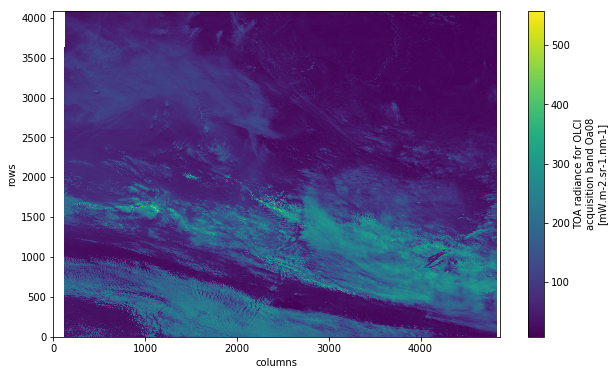

In [5]:
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa08_radiance'].plot.imshow()

## <a id='load_geo_coords'></a>Load OLCI geographic coordinates as `xarray`

If you want to georeference your image, you have to load the geographic coordinates file. You can load it as xarray with `open_dataset`. The file is called `geo_coordinates.nc`. You see that the file contains three variables: `latitude`, `longitude` and `altitude`.

Let's store the latitude and longitude data as `lat` and `lon` variables respectively.

In [6]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')
olci_geo_coords

<xarray.Dataset>
Dimensions:    (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes:
    absolute_orbit_number:  17886
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2019-07-26T05:53:27Z
    history:                  2019-07-26T05:53:27Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3A_OL_1_EFR____20190725T022702_20190725T023002_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2019-07-25T02:27:01.557172Z
    stop_time:              201

In [7]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

## <a id='channel_select'></a>Select OLCI channels for a RGB image

Depending on the combination of different OLCI channels, your RGB image might highlight specific phenomena. The channel combination for a True Color RGB image could be:
- Red: `Oa08_radiance`
- Green: `Oa06_radiance`
- Blue: `Oa04_radiance`

Let's define a function called `select_channels_for_rgb`, which makes the channel selection more flexible. The function returns the three bands individually.

In [8]:
def select_channels_for_rgb(xarray, red_channel, green_channel, blue_channel):
    return xarray[red_channel], xarray[green_channel], xarray[blue_channel]

In [9]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
red

<xarray.DataArray 'Oa08_radiance' (rows: 4091, columns: 4865)>
dask.array<open_dataset-11b331e91ecfa93159968e427c481fdeOa08_radiance, shape=(4091, 4865), dtype=float32, chunksize=(4091, 4865)>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa08_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa08
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

## <a id='image_processing'></a>Advanced image processing - Normalization and histogram equalization

#### Normalization

A common operation in image processing is the normalization of data values. Normalization changes the range of pixel intesity and can improve the constrast.
Let's define a function called `normalize`, which normalizes a numpy array into a scale between 0.0 and 1.0.

In [10]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

You can now apply the `normalize` function to each RGB channel. At the end, you can bring the three channels together into one `rgb` array with `numpy.dstack`. By verifying the shape of the resulting array, you see that the `rgb` array has now three dimensions.

In [11]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [12]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4091, 4865, 3)

You can now plot the rgb image to see if maybe further image processing methods could be applied. If you visualize the image with `plt.imshow()`, you see that the constrast is not very strong. A further step is to sharpen the contrast with the help of a **Histogram equalization**.

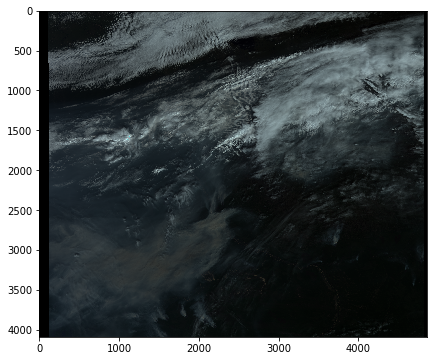

In [13]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

#### Histogram equalization

Histogram equalization is a method in image processing that adjusts the contrast using the image's histogram. Python's `skikit-learn` library has useful tools to make a histogram equalization quite straighforward. The `skimage` library provides a function `exposure.equalize_adaphtist()` which can be applied to the rgb data array.

In [14]:
rgb = exposure.equalize_adapthist(rgb)

You can again plot the rgb image with `plt.imshow()`. You can see that the histogram equalization improved the contrast of the image.

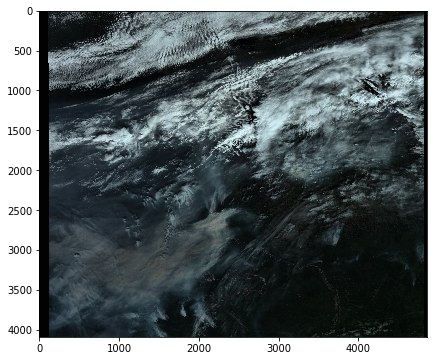

In [15]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

## <a id='visualize_tc'></a>Visualize a georeferenced RGB True Color image with `pcolormesh`

The final step is to georeference the `RGB` image. Therefore, you need the extracted `lat` and `lon` information you extracted above.

Let's plot the image with matplotlib's `pcolormesh` function. To be able to visualize the array as RGB, you have to map first the rgb are to a colour array.

In [294]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

The last step is to visualize the color array and add additional information, e.g. gridlines and coastlines. As you want to reuse the plotting code again, you can define a function called `visualize_s3_pcolormesh`.

In [320]:
def visualize_s3_pcolormesh(color_array, array, latitude, longitude, title):
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=ccrs.Mercator())
    ax.coastlines()

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    img1 = plt.pcolormesh(longitude, latitude, array*np.nan, color=colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree())
    ax.set_title(title, fontsize=20, pad=20.0)
    plt.show()

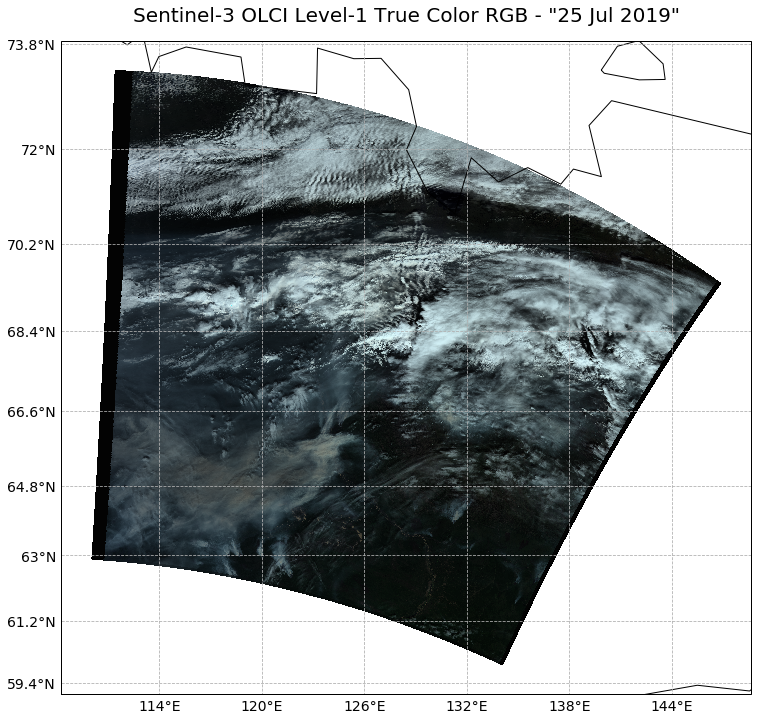

In [312]:
visualize_s3_pcolormesh(colorTuple, lat, lon, 'Sentinel-3 OLCI Level-1 True Color RGB - "25 Jul 2019"')

<br>

## <a id='false_color'></a>Create a False Color RGB image and plot it as georeferenced image 

A false color RGB image can be applied if specific phenomena should be highlighted. A channel combination for Sentinel-3 OLCI data could be:
- Red: `Oa17_radiance`
- Green: `Oa05_radiance`
- Blue: `Oa02_radiance`

This selection is advantageous to identify burnt areas and wildfires. The combination highlights healthy vegeation as red and burnt areas as black.

Let's repeat the steps from above to visualize the image as False Color RGB composite.

#### Select RGB channels

The first step is to select the channels `Oa17_radiance`, `Oa05_radiance` and `Oa02_radiance` as red, green and blue channels respectively.

In [313]:
red_fc, green_fc, blue_fc = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')

#### Normalize

You also want to normalize these channels and stack them afterwards into a three-dimensional array.

In [314]:
redn_fc = normalize(red_fc)
greenn_fc = normalize(green_fc)
bluen_fc = normalize(blue_fc)

In [315]:
rgb_fc = np.dstack((redn_fc, greenn_fc, bluen_fc))

#### Histogram equalization

Apply histogram equalization.

In [316]:
rgb_fc = exposure.equalize_adapthist(rgb_fc)

Let's have a sneak-peak to the un-georefrenced image with `plt.imshow()`

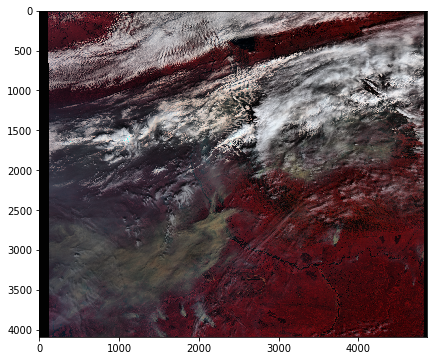

In [317]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb_fc)

#### Visualize with function `visualize_s3_pcolormesh`

In [318]:
mesh_rgb = rgb_fc[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

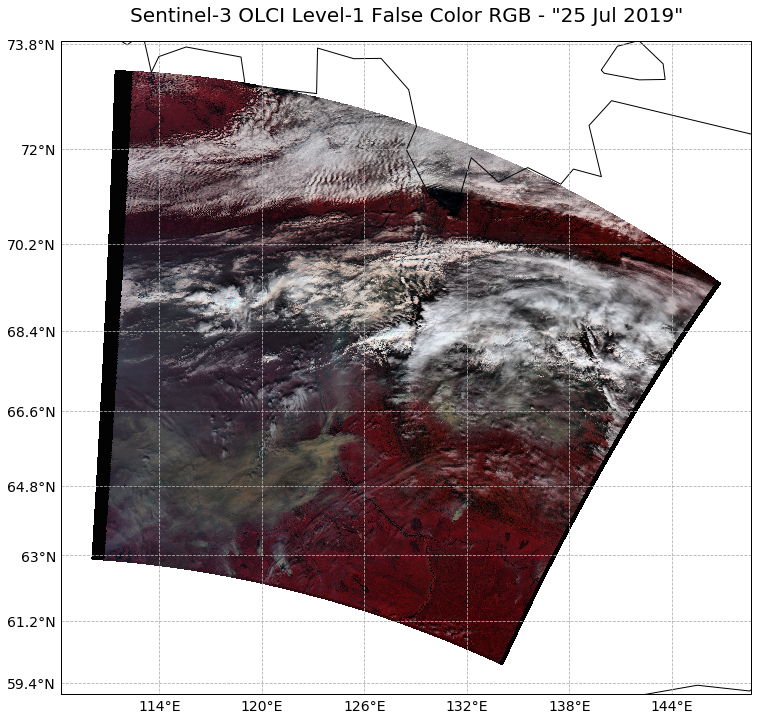

In [319]:
visualize_s3_pcolormesh(colorTuple, array, lat, lon, 'Sentinel-3 OLCI Level-1 False Color RGB - "25 Jul 2019"')

<br>

<a href="./24_ltpy_CAMS_data.ipynb"><< 24 - Copernicus Atmosphere Monitoring Service (CAMS) data </a><span style="float:right;"><a href="./31_ltpy_AC_SAF_GOME-2_L2_case_study.ipynb">31 - AC SAF GOME-2 Level 2 case study >></a></span>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>